In [2]:
##  "all_data.csv" file is required for the operation of the program.
##  "all_data.csv" file must be located in the same directory as the program.


##  the purpose of this code is to determine which features to use in the machine learning phase.
##  for this purpose, the importance weights of the attacks are calculated.
##  this calculation was made using sklearn-RandomForestRegressor.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
import sklearn as sk
import time
seconds = time.time()

## GridSearch

In [ ]:
def folder(f_name): #this function creates a folder named "feaure_pics" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

# CSV files names:
csv_files=["all_data.feather"]# It creates a list of file names in the "attacks" folder.

# Headers of column
main_labels=["Flow Duration","Total Fwd Packets",   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min",
    "Idle Mean","Idle Std","Idle Max", "Idle Min","Label"]

ths = open("importance_list_all_data.csv", "w")
folder("./feaure_pics/")
for j in csv_files:
    df=pd.read_feather(j)
    df = df[main_labels]
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]:#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"].values
    del df["Label"]
    X = df.values
   
   
    X = np.float32(X)
    X[np.isnan(X)] = 0
    X[np.isinf(X)] = 0
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    rf = sk.ensemble.RandomForestRegressor()
    params = {
          'max_depth':[None, 3, 4, 5, 6, 7, 8, 9, 10], 
          'min_samples_split':[2, 5, 10, 20],
          'min_samples_leaf':[1, 5, 10, 20],
        'n_estimators':[50, 100, 150, 250],
        'n_jobs':[-1]
    }
    gcv = RandomizedSearchCV(rf, cv=kfold, verbose=3, param_distributions=params)
    gcv.fit(X,y)

    #computing the feature importances
#     forest = sk.ensemble.RandomForestRegressor(max_depth=10, n_estimators=150, random_state=0, n_jobs=-1, verbose=3)
#     forest.fit(X, y)
#     importances = forest.feature_importances_
    importances = gcv.feature_importances_

#     std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)

    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(j[0:-4],"importance list:")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(j[0:-4]+" Attack - Feature Importance")
    plt.ylabel('Importance')
    #plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    #ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"secomds")
ths.close()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=3, min_samples_leaf=20, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=0.690 total time= 3.7min
[CV 2/5] END max_depth=3, min_samples_leaf=20, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=0.688 total time= 3.7min
[CV 3/5] END max_depth=3, min_samples_leaf=20, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=0.689 total time= 3.6min
[CV 4/5] END max_depth=3, min_samples_leaf=20, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=0.689 total time= 3.6min
[CV 5/5] END max_depth=3, min_samples_leaf=20, min_samples_split=10, n_estimators=50, n_jobs=-1;, score=0.687 total time= 3.7min
[CV 1/5] END max_depth=9, min_samples_leaf=5, min_samples_split=20, n_estimators=100, n_jobs=-1;, score=0.911 total time=19.4min
[CV 2/5] END max_depth=9, min_samples_leaf=5, min_samples_split=20, n_estimators=100, n_jobs=-1;, score=0.909 total time=19.4min
[CV 3/5] END max_depth=9, min_sample

## Random forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.1min


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 55.2min finished


all_data.fea importance list:
all_data.fea 
                              importance
Features                               
Bwd Packet Length Std          0.255541
Flow Bytes/s                   0.183915
Total Length of Fwd Packets    0.119303
Fwd Packet Length Std          0.067645
Flow IAT Std                   0.009947
Flow IAT Min                   0.004074
Fwd IAT Total                  0.003286
Flow Duration                  0.002430
Total Length of Bwd Packets    0.002312
Flow IAT Mean                  0.001901
Flow IAT Max                   0.001648
Bwd Packet Length Max          0.000787
Fwd Packet Length Mean         0.000767
Fwd Packet Length Min          0.000586
Bwd Packet Length Mean         0.000206
Total Backward Packets         0.000153
Flow Packets/s                 0.000147
Fwd Packet Length Max          0.000108
Total Fwd Packets              0.000079
Bwd Packet Length Min          0.000067 



all_data.fea=["Bwd Packet Length Std","Flow Bytes/s","Total Length of F

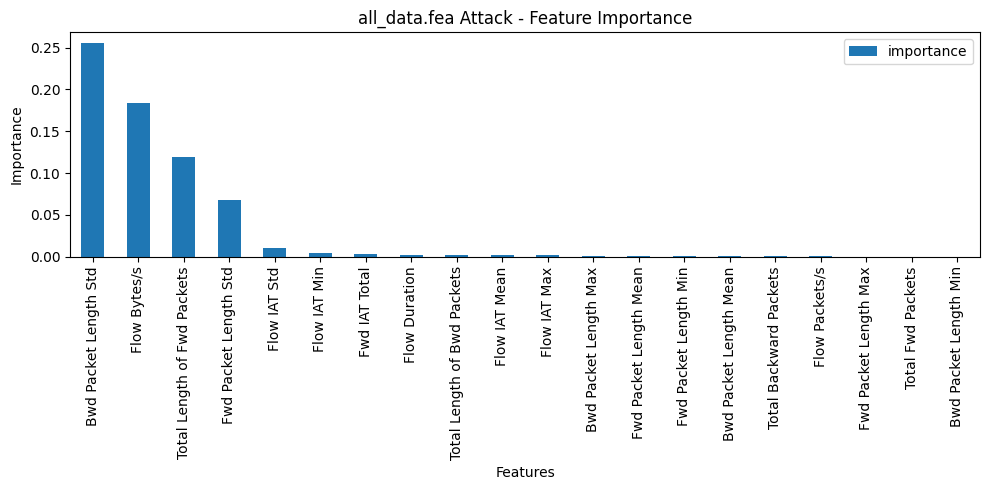

-----------------------------------------------------------------------------------------------




Total operation time: =  3324.5714292526245 secomds


In [3]:
def folder(f_name): #this function creates a folder named "feaure_pics" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

# CSV files names:
csv_files=["all_data.feather"]# It creates a list of file names in the "attacks" folder.

# Headers of column
main_labels=["Flow Duration","Total Fwd Packets",   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min",
    "Idle Mean","Idle Std","Idle Max", "Idle Min","Label"]

ths = open("importance_list_all_data.csv", "w")
folder("./feaure_pics/")
for j in csv_files:
    df=pd.read_feather(j)
    df = df[main_labels]
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]:#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"].values
    del df["Label"]
    X = df.values
   
   
    X = np.float32(X)
    X[np.isnan(X)] = 0
    X[np.isinf(X)] = 0

    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(max_depth=None, min_samples_leaf=20, min_samples_split=20, n_estimators=100, random_state=0, n_jobs=-1, verbose=3)
    forest.fit(X, y)
    importances = forest.feature_importances_
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    
    #printing the feature importances  
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(j[0:-4],"importance list:")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(j[0:-4]+" Attack - Feature Importance")
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")
    
print("Total operation time: = ",time.time()- seconds ,"secomds")
ths.close()